# Importing Libraries and Dataset

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
import kagglehub

# Download latest version
dataset_path = kagglehub.dataset_download("andrewmvd/hard-hat-detection")

print("Path to dataset files:", dataset_path)

# Data Preparation(spliting into train + validation + test data)

In [ ]:
import os
import shutil
from pathlib import Path
from sklearn.model_selection import train_test_split

image_dir = os.path.join(dataset_path, "images")
anno_dir = os.path.join(dataset_path, "annotations")

images = sorted(list(Path(image_dir).glob('*.png')))[:2000]
annotations = sorted(list(Path(anno_dir).glob('*.xml')))[:2000]

# Split data: 80% train, 10% val, 10% test
train_imgs, test_imgs, train_annos, test_annos = train_test_split(images, annotations, test_size=0.2, random_state=42)
val_imgs, test_imgs, val_annos, test_annos = train_test_split(test_imgs, test_annos, test_size=0.5, random_state=42)

# Step 5: Create directory structure
for split in ['train', 'val', 'test']:
    os.makedirs(f'helmet_dataset/{split}/images', exist_ok=True)
    os.makedirs(f'helmet_dataset/{split}/annotations', exist_ok=True)

# Step 6: Copy train files
for img, anno in zip(train_imgs, train_annos):
    shutil.copy(img, f'helmet_dataset/train/images/{img.name}')
    shutil.copy(anno, f'helmet_dataset/train/annotations/{anno.name}')

# Step 7: Copy val files
for img, anno in zip(val_imgs, val_annos):
    shutil.copy(img, f'helmet_dataset/val/images/{img.name}')
    shutil.copy(anno, f'helmet_dataset/val/annotations/{anno.name}')

# Step 8: Copy test files
for img, anno in zip(test_imgs, test_annos):
    shutil.copy(img, f'helmet_dataset/test/images/{img.name}')
    shutil.copy(anno, f'helmet_dataset/test/annotations/{anno.name}')

In [ ]:
print(f"Train Images: {len(train_imgs)}")
print(f"Validation Images: {len(val_imgs)}")
print(f"Test Images: {len(test_imgs)}")

In [ ]:
import os
import numpy as np
import torch
import torchvision
from PIL import Image
import xml.etree.ElementTree as ET
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.transforms import functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T

# Define class mapping
CLASS_NAME = ['helmet', 'head', 'person']
CLASS_MAP = {name: idx + 1 for idx, name in enumerate(CLASS_NAME)}  # 0 reserved for background

# Custom Dataset
class HelmetDataset(Dataset):
    def __init__(self, image_dir, annotation_dir, transforms=None):
        self.image_dir = image_dir
        self.annotation_dir = annotation_dir
        self.transforms = transforms
        self.image_files = sorted(os.listdir(image_dir))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Load image
        img_filename = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_filename)
        image = Image.open(img_path).convert("RGB")

        # Load annotation
        xml_path = os.path.join(self.annotation_dir, img_filename.replace('.png', '.xml').replace('.jpg', '.xml'))
        boxes = []
        labels = []

        tree = ET.parse(xml_path)
        root = tree.getroot()
        for obj in root.findall('object'):
            label = obj.find('name').text
            labels.append(CLASS_MAP[label])
            bndbox = obj.find('bndbox')
            xmin = int(bndbox.find('xmin').text)
            ymin = int(bndbox.find('ymin').text)
            xmax = int(bndbox.find('xmax').text)
            ymax = int(bndbox.find('ymax').text)
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        target = {
            'boxes': boxes,
            'labels': labels,
            'image_id': torch.tensor([idx])
        }

        if self.transforms:
            image = self.transforms(image)

        return image, target


# Data Augmentation and Data loading

In [ ]:
# Define the transformation function
transform = T.Compose([
    T.Resize((415, 415)),
    T.RandomHorizontalFlip(p=0.5),
    T.GaussianBlur(kernel_size=5, sigma=(0.1, 2.0)),
    T.ToTensor(),
])

# Dataset and DataLoader
train_dataset = HelmetDataset("helmet_dataset/train/images", "helmet_dataset/train/annotations", transform)
val_dataset = HelmetDataset("helmet_dataset/val/images", "helmet_dataset/val/annotations", transform)

BATCH_SIZE = 8
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

# Creating Model

In [ ]:
model = fasterrcnn_resnet50_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes=len(CLASS_NAME)+1)

# Train
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0005)

# Model Training

In [ ]:
# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for images, targets in train_loader:
        images = list(img.to(device) for img in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        epoch_loss += losses.item()

    print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {epoch_loss:.4f}")

Epoch [1/5] Loss: 140.7585
Epoch [2/5] Loss: 113.8749
Epoch [3/5] Loss: 106.2344
Epoch [4/5] Loss: 104.0831


# Saving the model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/helmet_dataset/fasterrcnn_helmet.pth')

### Load saved model

In [ ]:
# model.load_state_dict(torch.load('/content/drive/MyDrive/helmet_dataset/fasterrcnn_helmet.pth', map_location='cpu'))
# model.eval()

## Test Loader

In [ ]:
test_dataset = HelmetDataset("helmet_dataset/test/images", "helmet_dataset/test/annotations", transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

# Inference + Visualization

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def visualize_predictions(model, dataset, idx=0, threshold=0.5):
    model.eval()
    image, target = dataset[idx]
    with torch.no_grad():
        prediction = model([image.to(device)])[0]

    image_np = image.permute(1, 2, 0).cpu().numpy()
    fig, ax = plt.subplots(1, figsize=(10, 8))
    ax.imshow(image_np)

    for box, score, label in zip(prediction['boxes'], prediction['scores'], prediction['labels']):
        if score >= threshold:
            xmin, ymin, xmax, ymax = box.cpu().numpy()
            class_name = CLASS_NAME[label.item() - 1]  # background is 0
            ax.add_patch(patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor='g', facecolor='none'))
            ax.text(xmin, ymin, f'{class_name}: {score:.2f}', fontsize=12, color='white', bbox=dict(facecolor='green', alpha=0.5))

    plt.axis('off')
    plt.show()


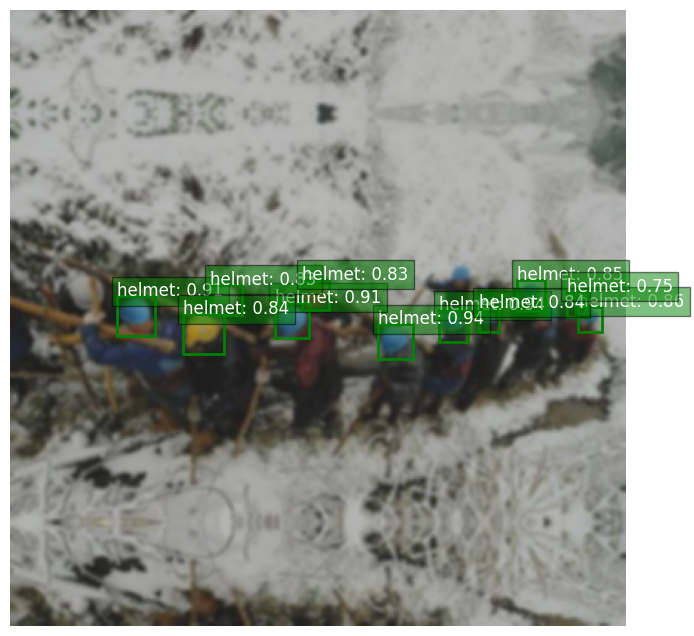

In [ ]:
visualize_predictions(model, test_dataset, idx=1, threshold=0.7)

# mAP and IoU Evaluation

In [ ]:
!pip install torchmetrics

In [ ]:
from torchmetrics.detection.mean_ap import MeanAveragePrecision

def evaluate_model(model, data_loader, device):
    model.eval()
    metric = MeanAveragePrecision(iou_type="bbox")  # COCO-style mAP & IoU

    for images, targets in data_loader:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        with torch.no_grad():
            preds = model(images)

        metric.update(preds, targets)

    results = metric.compute()

    print(f"Evaluation Results:")
    print(f"  • mAP@IoU=0.50: {results['map_50']:.4f}")
    print(f"  • mAP@IoU=0.75: {results['map_75']:.4f}")
    print(f"  • mAP@[0.5:0.95]: {results['map']:.4f}")
    print(f"  • Mean IoU: {results['map']:.4f}")

evaluate_model(model, test_loader, device)